#VAE

##Setup

###imports

In [ ]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import copy
from datetime import datetime
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

###Mount drive 

**please enter your path to the folder here:**

In [ ]:
your_path = ''  #fill if folder has an inner directorry in your drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive'+your_path

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### parameters

In [ ]:
# parameters
IMG_SHAPE = [28, 28, 1]
IMG_SIZE = 28*28
INNER_SIZE = 600
LATENT_DIM = 50
LEARNING_RATE = 0.001
BATCH_SIZE = 100
N_EPOCHS = 30
DROP_PROB = 0.1
BETA = 0.01
TRAIN = False
#TRAIN = True

###GPU
Working on gpu is prefered. we will check if gpu is available

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  DEVICE = 'cpu'
  print('CUDA is not available.  Training on CPU ...')
else:
  DEVICE = 'cuda'
  print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### Load data

In [ ]:
# Download the data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, 
                                 train=True, transform=transforms.ToTensor())
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, 
                                train=False, transform=transforms.ToTensor())
# load the data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, 
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, 
                                         shuffle=False)



## **Architecture**
Now we build our networks

###Encoder

In [ ]:
# define encoder architecture
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc12 = nn.Sequential(nn.Linear(IMG_SIZE, INNER_SIZE), 
                              nn.BatchNorm1d(INNER_SIZE),
                              nn.Softplus(),
                              nn.Dropout(DROP_PROB),
                              nn.Linear(INNER_SIZE, INNER_SIZE), 
                              nn.BatchNorm1d(INNER_SIZE),
                              nn.Softplus(),
                              nn.Dropout(DROP_PROB))
    self.fc_mean = nn.Linear(INNER_SIZE, LATENT_DIM)
    self.fc_var = nn.Linear(INNER_SIZE, LATENT_DIM)
        
  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.fc12(x)
    log_z_var = self.fc_var(x)
    z_mean = self.fc_mean(x)
    #sample epsilon
    std = log_z_var.mul(0.5).exp_()
    epsilon = Variable(std.data.new(std.size()).normal_()).to(DEVICE)
    z = z_mean + std * epsilon
    return z, z_mean, log_z_var
  

###Decoder

In [ ]:

# define decoder architecture
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.im_shape = IMG_SHAPE
    self.fc12_out = nn.Sequential(nn.Linear(LATENT_DIM, INNER_SIZE), 
                              nn.BatchNorm1d(INNER_SIZE),
                              nn.Softplus(),
                              nn.Dropout(DROP_PROB),
                              nn.Linear(INNER_SIZE, INNER_SIZE), 
                              nn.BatchNorm1d(INNER_SIZE),
                              nn.Softplus(),
                              nn.Dropout(DROP_PROB),
                              nn.Linear(INNER_SIZE, IMG_SIZE), 
                              nn.BatchNorm1d(IMG_SIZE),
                              nn.Sigmoid())
                              
  def forward(self, x):
    x = self.fc12_out(x)
    x = x.view(x.size(0), self.im_shape[2], self.im_shape[0], self.im_shape[1])
    return x
    

###VAE model

In [ ]:
# define VAE architecture
class VAE(nn.Module):
  def __init__(self):
    super().__init__()
    self.im_shape = IMG_SHAPE
    self.encoder = Encoder()
    self.decoder = Decoder()
    for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight.data, 0, 0.001)
                if m.bias is not None:
                    m.bias.data.zero_()
  def forward(self, x):
    z, z_mean, log_z_var = self.encoder(x)
    x_gener = self.decoder(z)
    return x_gener, z, z_mean, log_z_var

    

##Train and test 

###Train function

In [ ]:
def train(trainloader, model, milestones, factor):
  
  optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1/factor)
  
  for epoch in range(N_EPOCHS):
    running_loss = 0
    model.train()
    criterion = nn.BCELoss(reduction='sum')

    for images, labels in trainloader:
        optimizer.zero_grad()    
        images = images.to(DEVICE)
        
        # Forward pass
        gener_x, z, z_mean, log_z_var = model(images)
        
        #define loss
        kl_loss = torch.mean(-0.5 * torch.sum(1 + log_z_var - z_mean.pow(2) - log_z_var.exp(), dim=1))
        images = images.view(images.size(0),-1)
        gener_x = gener_x.view(gener_x.size(0),-1)
        BCE_loss = IMG_SIZE*F.binary_cross_entropy(gener_x, images) 
        loss = BETA*kl_loss + BCE_loss
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    scheduler.step()
    total_loss = running_loss/len(trainloader.dataset)

    print("Epoch: {}/{}.. ".format(epoch+1, N_EPOCHS),
        "Training Loss: {:.3f}.. ".format(total_loss))
    
  # Save weights
  torch.save(model.state_dict(), path+'/VAE.pth')

###Train VAE and test it

Epoch: 1/30..  Training Loss: 3.981.. 
Epoch: 2/30..  Training Loss: 3.174.. 
Epoch: 3/30..  Training Loss: 2.786.. 
Epoch: 4/30..  Training Loss: 2.562.. 
Epoch: 5/30..  Training Loss: 2.435.. 
Epoch: 6/30..  Training Loss: 2.359.. 
Epoch: 7/30..  Training Loss: 2.315.. 
Epoch: 8/30..  Training Loss: 2.287.. 
Epoch: 9/30..  Training Loss: 2.266.. 
Epoch: 10/30..  Training Loss: 2.252.. 
Epoch: 11/30..  Training Loss: 2.240.. 
Epoch: 12/30..  Training Loss: 2.231.. 
Epoch: 13/30..  Training Loss: 2.223.. 
Epoch: 14/30..  Training Loss: 2.218.. 
Epoch: 15/30..  Training Loss: 2.211.. 
Epoch: 16/30..  Training Loss: 2.207.. 
Epoch: 17/30..  Training Loss: 2.202.. 
Epoch: 18/30..  Training Loss: 2.199.. 
Epoch: 19/30..  Training Loss: 2.194.. 
Epoch: 20/30..  Training Loss: 2.191.. 
Epoch: 21/30..  Training Loss: 2.182.. 
Epoch: 22/30..  Training Loss: 2.179.. 
Epoch: 23/30..  Training Loss: 2.178.. 
Epoch: 24/30..  Training Loss: 2.178.. 
Epoch: 25/30..  Training Loss: 2.179.. 
Epoch: 26

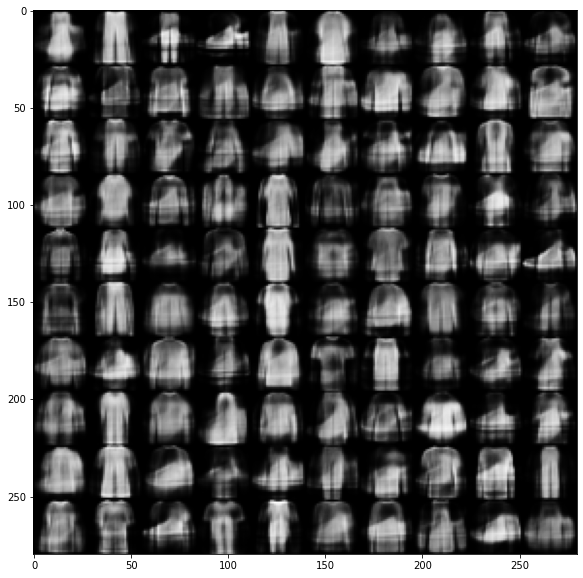

In [ ]:
if TRAIN == True:
  model = VAE()
  model = model.to(DEVICE)
  optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)
  train(trainloader, model, milestones=[20], factor=10)


# examine image generation
model = VAE()
model.load_state_dict(torch.load(path+'/VAE.pth'))
model.to(DEVICE)

n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
model.eval()
for j in range(n):
    for i in range(n):
        z_sample  = np.random.normal(size=LATENT_DIM).reshape(1, LATENT_DIM)
        z_sample  = torch.from_numpy(z_sample).float().cuda()
        x_gener = model.decoder(z_sample)
        x_gener = x_gener.cpu().data.numpy()
        digit = x_gener.reshape(digit_size, digit_size, IMG_SHAPE[2])

        d_x = i * digit_size
        d_y = j * digit_size
        figure[d_x:d_x + digit_size, d_y:d_y + digit_size] = digit[:, :, 0]

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()

#SVM

##Reload data

In [ ]:
x_train, y_train = trainset.data.float(), trainset.targets.float()
x_test, y_test   = testset.data.float(), testset.targets.float()

##Define model

In [ ]:
#VAE model
vae_model = VAE()
vae_model.load_state_dict(torch.load(path+'/VAE.pth'))
vae_model.to(DEVICE)

mode = 'test'
#mode = 'train'

##train and test svm

In [ ]:
for sample_size in [100, 600, 1000, 3000]:  # on how much data to train the svm
    
    #SVM Model
    svm_model = SVC()  # the svm classifier
    
    #sample
    sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size, random_state=222) #fixed seed
    _, index = sss.split(x_train.cpu().numpy(), y_train.cpu().numpy())
    x, y = x_train[index[1]], y_train[index[1]]
    
    #train or load
    if mode == 'train':
        x_latent, _, _ = vae_model.encoder(x.cuda())
        x_latent = x_latent.detach().cpu().numpy()
        svm_model.fit(x_latent, y)
        #   save model
        torch.save(svm_model, path+'/SVM_{}.sav'.format(sample_size))
    else:
        svm_model = torch.load(path+'/SVM_{}.sav'.format(sample_size))     
    
    # test
    x_test_latent, _, _ = vae_model.encoder(x_test.cuda())
    x_test_latent = x_test_latent.detach().cpu().numpy()
    y_pred = svm_model.predict(x_test_latent)
    score = accuracy_score(y_test, y_pred)
    print('Fitting SVM with {} samples...'.format(sample_size),
          'Accuracy: %.1f %%' % (100. * score))




Fitting SVM with 100 samples... Accuracy: 66.9 %
Fitting SVM with 600 samples... Accuracy: 79.1 %
Fitting SVM with 1000 samples... Accuracy: 80.6 %
Fitting SVM with 3000 samples... Accuracy: 83.9 %
